讀取資料

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
data=pd.read_csv('/content/drive/MyDrive/守燦_碩士論文實作/CCPD/CCPD_EDA.csv')

Mounted at /content/drive


自然語言處理與GloVe模型建立

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


讀取資料集完成


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


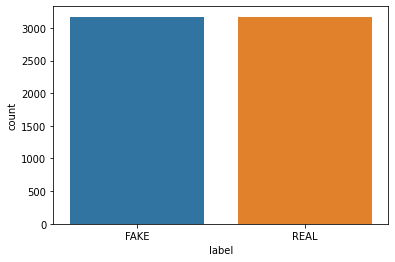

                                               title  \
0                       You Can Smell Hillary’s Fear   
1  Watch The Exact Moment Paul Ryan Committed Pol...   
2        Kerry to go to Paris in gesture of sympathy   
3  Bernie supporters on Twitter erupt in anger ag...   
4   The Battle of New York: Why This Primary Matters   

                                                text  label  
0  Daniel Greenfield, a Shillman Journalism Fello...      1  
1  Google Pinterest Digg Linkedin Reddit Stumbleu...      1  
2  U.S. Secretary of State John F. Kerry said Mon...      0  
3  — Kaydee King (@KaydeeKing) November 9, 2016 T...      1  
4  It's primary day in New York and front-runners...      0  
0    Daniel Greenfield  a Shillman Journalism Fello...
1    Google Pinterest Digg Linkedin Reddit Stumbleu...
2    U S  Secretary of State John F  Kerry said Mon...
3      Kaydee King   KaydeeKing  November 9  2016 T...
4    It s primary day in New York and front runners...
Name: text, dtyp

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


Embedding Matrix: 
 [[-0.19141833 -0.76908656 -0.20560923 ...  0.05107098  0.84699764
   0.081525  ]
 [-0.15730999 -0.75502998  0.36844999 ... -0.54136997  0.67817003
  -0.17251   ]
 [-0.13128    -0.45199999  0.043399   ... -0.30526    -0.045495
   0.56509   ]
 ...
 [ 0.29367     0.30923    -0.57261002 ...  0.31319001  1.06340003
   0.87199998]
 [ 0.096458    0.089318   -0.55539    ... -0.11839     0.51749003
  -0.34305   ]
 [ 0.10278    -0.15757    -0.099743   ... -0.62444001 -0.085119
  -0.16683   ]]
Embedding Matrix size:  (10000, 100)
建立GloVe預訓練模型-完成


In [2]:
#套件載入
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from tensorflow.keras.preprocessing import text,sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Embedding,LSTM,Bidirectional,Dense
#讀取資料集
#data=pd.read_csv('news1_eda.csv')
print("讀取資料集完成")
#觀查label欄位資料平衡的狀況
sns.countplot(data['label'])
plt.show()
#label欄位資料轉換(fake:1,true:0)
mapping={'FAKE':1,'REAL':0}
data=data.replace({'label': mapping})
print(data.head())
#自然語言處理-字詞正則化
def irrelevant(text):
    return re.sub('[^a-zA-Z0-9]',' ',text)
data['text']=data['text'].apply(irrelevant)
print(data['text'].head())
print("字詞正則化-完成")
#自然語言處理-轉換所有字母為小寫
def lowering(text):
    return str(text).lower()
data['text']=data['text'].apply(lowering)
print(data['text'].head())
print("轉換所有字母為小寫-完成")
#自然語言處理-斷詞
def token(text):
    return word_tokenize(text)
data['text']=data['text'].apply(token)
print(data['text'].head())
print('斷詞-完成')
#自然語言處理-移除停用字
stopwords=set(stopwords.words('english'))
def stop_words(text):
    return [item for item in text if item not in stopwords]
data['text']=data['text'].apply(stop_words)
print(data['text'].head())
print("移除停用字-完成")
#定義X與Y
y=data["label"] #Fake或True
x=data['text'] #內文
#切割資料集
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=0)
print("切割資料集-完成")
#自然語言處理-標註向量與填充文字(Tokenization,Padding):用向量表示每個詞彙，以利後續GloVe模型建立。
max_len=300
tokenizer=text.Tokenizer(num_words=max_len) #標註內文的限制為內文最多300字，若少於300字則進行填充並截斷長字
tokenizer.fit_on_texts(x_train) #將內文所有詞彙的向量映射保存在Glove分詞器的word_index屬性中
tokenized_train=tokenizer.texts_to_sequences(x_train) #標註訓練集內文
x_train=sequence.pad_sequences(tokenized_train,maxlen=max_len) #填充訓練集內文
tokenized_test=tokenizer.texts_to_sequences(x_test) #標註測試集內文
x_test=sequence.pad_sequences(tokenized_test,maxlen=max_len) #填充測試集內文
print("標註與填充文字-完成")
#解決資料不平衡(SMOTE)
# x_train,y_train=SMOTE().fit_resample(x_train,y_train)
#觀察SMOTE平衡後的資料分佈
# sns.countplot(y_train)
# plt.show()
# print("資料不平衡處理完成")
#建立GloVe預訓練模型
max_features=10000 #詞彙共現矩陣的最大特徵為10000
embedding_file="/content/drive/MyDrive/守燦_碩士論文實作/預訓練資源檔/glove.6B.100d.txt" #GloVe預訓練模型的檔案
def get_coeffs(word,*arr): #定義文字轉換為數字的運作方法
    return word,np.asarray(arr,dtype='float32')
embedding_index=dict(get_coeffs(*o.rstrip().rsplit(' ')) for o in open(embedding_file,encoding='utf-8')) #利用get_coeffs方法載入預訓練檔案，得到預訓練檔案的數值並儲存在字典中
embeds=np.stack(embedding_index.values()) #將字典裡的數值嵌入至新的序列
emb_mean,emb_std=embeds.mean(),embeds.std() #計算嵌入的平均數與標準差
embed_size=embeds.shape[1] #計算嵌入值序列的資料維度
word_index=tokenizer.word_index #Glove模型的分詞器
nb_words=min(max_features,len(word_index)) #定義最小特徵與最小維度需與GloVe分詞器一致
embedding_matrix=np.random.normal(emb_mean,emb_std,(nb_words,embed_size)) #詞彙共現性矩陣是經由嵌入的平均數、標準差、Glove分詞器三者的常態擬和求得
for word, i in word_index.items():#進行文字轉換為文字向量，完成預訓練，求出詞彙共現性矩陣
    if i >= max_features: continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector
print("Embedding Matrix: \n",embedding_matrix)
print("Embedding Matrix size: ",embedding_matrix.shape)
print("建立GloVe預訓練模型-完成")

嵌入Glove至BiLSTM模型訓練

In [3]:
#定義BiLSTM模型參數
batch_size=128
epochs=20
embed_size=100
#建立BiLSTM模型
model=Sequential()
model.add(Embedding(max_features,output_dim=embed_size,weights=[embedding_matrix],input_length=max_len,trainable=False)) #匯入GloVe預訓練模型
model.add(LSTM(64,return_sequences=True))
model.add(LSTM(32,return_sequences=False))
model.add(Dense(16,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer=optimizers.Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])
print(model.summary())
print("BiLSTM模型建立-完成")
#訓練BiLSTM模型
history=model.fit(x_train,y_train,batch_size=batch_size,validation_data=(x_test,y_test),epochs=epochs)
print("BiLSTM模型訓練-完成")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          1000000   
                                                                 
 lstm (LSTM)                 (None, 300, 64)           42240     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,055,201
Trainable params: 55,201
Non-trainable params: 1,000,000
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


None
BiLSTM模型建立-完成
Epoch 1/20
35/35 [==============================] - 10s 55ms/step - loss: 0.5948 - accuracy: 0.6829 - val_loss: 0.4615 - val_accuracy: 0.7985
Epoch 2/20
35/35 [==============================] - 1s 28ms/step - loss: 0.4755 - accuracy: 0.7806 - val_loss: 0.4425 - val_accuracy: 0.8048
Epoch 3/20
35/35 [==============================] - 1s 29ms/step - loss: 0.3991 - accuracy: 0.8248 - val_loss: 0.3581 - val_accuracy: 0.8385
Epoch 4/20
35/35 [==============================] - 1s 29ms/step - loss: 0.3532 - accuracy: 0.8482 - val_loss: 0.3452 - val_accuracy: 0.8580
Epoch 5/20
35/35 [==============================] - 1s 29ms/step - loss: 0.3375 - accuracy: 0.8631 - val_loss: 0.3100 - val_accuracy: 0.8674
Epoch 6/20
35/35 [==============================] - 1s 29ms/step - loss: 0.3138 - accuracy: 0.8699 - val_loss: 0.3240 - val_accuracy: 0.8701
Epoch 7/20
35/35 [==============================] - 1s 29ms/step - loss: 0.3252 - accuracy: 0.8672 - val_loss: 0.3464 - val_accuracy: 

模型績效評估(準確度、損失函數、分類報告、混淆矩陣)

In [4]:
#準確度評估
print("訓練集的模型準確度: " ,model.evaluate(x_train,y_train)[1]*100 , "%")
print("測試集的模型準確度: " ,model.evaluate(x_test,y_test)[1]*100 , "%")

139/139 [==============================] - 2s 16ms/step - loss: 0.1617 - accuracy: 0.9380
訓練集的模型準確度:  93.79792809486389 %
60/60 [==============================] - 1s 19ms/step - loss: 0.2625 - accuracy: 0.9116
測試集的模型準確度:  91.16254448890686 %


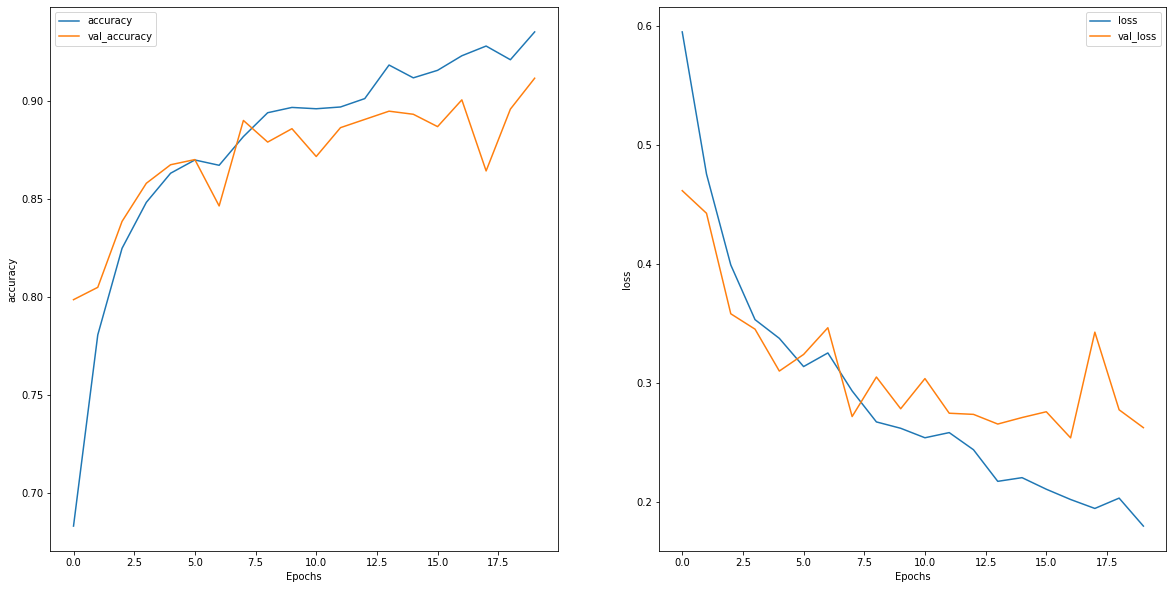

In [5]:
#繪製準確度變化與損失函數圖
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric],'')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric,'val_'+metric])
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plot_graphs(history,'accuracy')
plt.subplot(1,2,2)
plot_graphs(history,'loss')

In [6]:
#分類報告
prediction=(model.predict(x_test)>0.5).astype("int32")
print("分類報告: ",classification_report(y_test,prediction,digits=4))

60/60 [==============================] - 1s 10ms/step
分類報告:                precision    recall  f1-score   support

           0     0.9098    0.9174    0.9136       968
           1     0.9135    0.9057    0.9096       933

    accuracy                         0.9116      1901
   macro avg     0.9117    0.9115    0.9116      1901
weighted avg     0.9116    0.9116    0.9116      1901



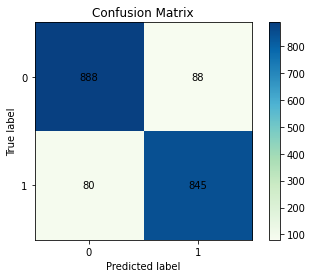

In [7]:
#繪製混淆矩陣
def plot_confusion_matrix(confusion_mat):
    plt.imshow(confusion_mat,interpolation='nearest',cmap=plt.cm.GnBu)
    plt.colorbar()
    for x in range(len(confusion_mat)):
        for y in range(len(confusion_mat)):
            plt.annotate(confusion_mat[x, y], xy=(x, y),horizontalalignment='center',verticalalignment='center')
    plt.title('Confusion Matrix')    
    plt.ylabel('True label')         
    plt.xlabel('Predicted label')     
    tick_marks = np.arange(2)
    plt.xticks(tick_marks,tick_marks)
    plt.yticks(tick_marks,tick_marks)
    plt.show()
from sklearn import metrics
confusion_mat=metrics.confusion_matrix(y_test,prediction,labels=None,sample_weight=None)
plot_confusion_matrix(confusion_mat)